In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt


In [2]:
#Load Dataset
data = pd.read_csv("/files/capstone_project/principal_data2.csv", sep=";", engine="python")

In [16]:
data.head()

,Ticker,Name,Sector,Industry,ESG Global Score,Market Cap,Size,Debt-to-Equity,PE_Ratio,Beta_Value,...,Momentum_1y,High_Impact_ESG,ESG_x_Sector,Tot_Return_w,Next_Year_Return_w,Size_w,PE_Ratio_w,Debt-to-Equity_w,ROE_Value_w,Momentum_1y_w
0,CCI.N,crown castle,Real Estate,REIT - Specialty,30.652416,28854529490,10.460214,171.38638,66.509209,0.956088,...,NaN,1,"30,65241605",14.327418,4.500617,10.460214,66.509209,171.38638,6.972681,NaN
1,CCI.N,crown castle,Real Estate,REIT - Specialty,33.828336,31289683876,10.495401,161.05540,66.761560,0.956088,...,14.327418,1,"33,82833598",4.500617,32.925532,10.495401,66.761560,161.05540,4.424099,14.327418
2,CCI.N,crown castle,Real Estate,REIT - Specialty,37.630940,45100597852,10.654182,130.96290,87.986558,0.956088,...,4.500617,1,"37,63093958",32.925532,1.735604,10.654182,87.986558,130.96290,3.246854,4.500617
3,CCI.N,crown castle,Real Estate,REIT - Specialty,61.045950,45065203514,10.653841,144.17077,81.884790,0.956088,...,32.925532,1,"61,04595033",1.735604,35.464509,10.653841,81.884790,144.17077,4.257621,32.925532
4,CCI.N,crown castle,Real Estate,REIT - Specialty,65.033748,59101487726,10.771598,172.76194,87.056907,0.956088,...,1.735604,1,"65,03374816",35.464509,15.608315,10.771598,87.056907,172.76194,6.772439,1.735604


In [3]:
#Drop Next Year return NaNs
data = data.dropna(subset=['Next_Year_Return_w'])

In [4]:
features = ["ESG Global Score", "Size", "PE_Ratio_w", "Debt-to-Equity_w", "ROE_Value_w" ,"Momentum_1y_w", "Beta_Value", "High_Impact_ESG", "ESG_x_Sector"]

X = data[features]
y = data["Next_Year_Return_w"]



In [5]:
data[features].dtypes

ESG Global Score    float64
Size                float64
PE_Ratio_w          float64
Debt-to-Equity_w    float64
ROE_Value_w         float64
Momentum_1y_w       float64
Beta_Value          float64
High_Impact_ESG       int64
ESG_x_Sector         object
dtype: object

In [6]:
for col in features:
    data[col] = (
        data[col]
        .astype(str)          
        .str.replace(",", ".") 
        .astype(float)         
    )


In [7]:
for col in features:
    # 1) imputation par secteur
    data[col] = data.groupby("Sector")[col].transform(
        lambda x: x.fillna(x.median())
    )
    # 2) si encore NaN, imputation par médiane globale
    data[col] = data[col].fillna(data[col].median())

/files/myenv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/files/myenv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/files/myenv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/files/myenv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/files/myenv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/files/myenv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean

In [8]:
data["Next_Year_Return_w"].isna().sum()

np.int64(0)

In [9]:
#Clean Next_Year_Return_w
data = data[~data["Next_Year_Return_w"].isna()]

In [10]:
data.head()

,Ticker,Name,Sector,Industry,ESG Global Score,Market Cap,Size,Debt-to-Equity,PE_Ratio,Beta_Value,...,Momentum_1y,High_Impact_ESG,ESG_x_Sector,Tot_Return_w,Next_Year_Return_w,Size_w,PE_Ratio_w,Debt-to-Equity_w,ROE_Value_w,Momentum_1y_w
0,CCI.N,crown castle,Real Estate,REIT - Specialty,30.652416,28854529490,10.460214,171.38638,66.509209,0.956088,...,NaN,1.0,30.652416,14.327418,4.500617,10.460214,66.509209,171.38638,6.972681,6.337966
1,CCI.N,crown castle,Real Estate,REIT - Specialty,33.828336,31289683876,10.495401,161.05540,66.761560,0.956088,...,14.327418,1.0,33.828336,4.500617,32.925532,10.495401,66.761560,161.05540,4.424099,14.327418
2,CCI.N,crown castle,Real Estate,REIT - Specialty,37.630940,45100597852,10.654182,130.96290,87.986558,0.956088,...,4.500617,1.0,37.630940,32.925532,1.735604,10.654182,87.986558,130.96290,3.246854,4.500617
3,CCI.N,crown castle,Real Estate,REIT - Specialty,61.045950,45065203514,10.653841,144.17077,81.884790,0.956088,...,32.925532,1.0,61.045950,1.735604,35.464509,10.653841,81.884790,144.17077,4.257621,32.925532
4,CCI.N,crown castle,Real Estate,REIT - Specialty,65.033748,59101487726,10.771598,172.76194,87.056907,0.956088,...,1.735604,1.0,65.033748,35.464509,15.608315,10.771598,87.056907,172.76194,6.772439,1.735604


In [24]:
#save data

data.to_csv("/files/capstone_project/principal_data_cleaned.csv", sep=";", index=False)


In [10]:
#Create Expanding Window Split


splits = []
years = sorted(data["Year"].unique())

for test_year in [2022, 2023, 2024]:
    if test_year in years:
        train_years = [y for y in years if y < test_year]
        splits.append((train_years, test_year))



   

In [11]:
windows = []

for train_years, test_year in splits:
    train = data[data['Year'].isin(train_years)]
    test = data[data['Year'] == test_year]

    X_train = train[features]
    y_train = train["Next_Year_Return_w"]

    X_test = test[features]
    y_test = test["Next_Year_Return_w"]

    windows.append((X_train, y_train, X_test, y_test))
   

In [12]:
#Standardize features

scalers = []
scaled_windows = []

for (X_train, y_train, X_test, y_test) in windows:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    scalers.append(scaler)
    scaled_windows.append((X_train_scaled, y_train, X_test_scaled, y_test))


In [13]:
#Model 1 is Linear Regression



lr_results = []

for window in scaled_windows:
    X_train_scaled, y_train, X_test_scaled, y_test = window
    
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    preds = lr.predict(X_test_scaled)
    lr_results.append({
        "mse": mean_squared_error(y_test, preds),
        "r2": r2_score(y_test, preds)
    })

lr_results





[{'mse': 1468.5922230351457, 'r2': 0.07910116758046914},
 {'mse': 1075.9364621996872, 'r2': 0.03308187242864702}]

In [14]:
#Model 2 is Lasso Regression


lasso_results = []
lasso_coefs = []

for window in scaled_windows:
    X_train_scaled, y_train, X_test_scaled, y_test = window
    
    lasso = LassoCV(
        alphas=np.logspace(-3, 1, 20),
        cv=5,
        random_state=0
    )
    lasso.fit(X_train_scaled, y_train)
    preds = lasso.predict(X_test_scaled)
    
    lasso_results.append({
        "alpha": lasso.alpha_,
        "mse": mean_squared_error(y_test, preds),
        "r2": r2_score(y_test, preds)
    })
    lasso_coefs.append(lasso.coef_)
lasso_results


[{'alpha': np.float64(0.20691380811147903),
  'mse': 1483.8573284932131,
  'r2': 0.06952899528335432},
 {'alpha': np.float64(0.20691380811147903),
  'mse': 1077.9731730754747,
  'r2': 0.031251529526804656}]

In [15]:
#Model 3 is Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
rf_results = []
for window in scaled_windows:
    X_train_scaled, y_train, X_test_scaled, y_test = window
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)
    preds = rf.predict(X_test_scaled)
    rf_results.append({
        "mse": mean_squared_error(y_test, preds),
        "r2": r2_score(y_test, preds)
    })
rf_results       # convertir en float
    

[{'mse': 1466.8836192876352, 'r2': 0.08017256859395017},
 {'mse': 1020.3082482540042, 'r2': 0.08307360554505461}]

In [34]:
rf_feature_importances = dict(zip(features, rf.feature_importances_))
rf_feature_importances

{'ESG Global Score': np.float64(0.10210099629158444),
 'Size': np.float64(0.1742581185132542),
 'PE_Ratio_w': np.float64(0.11697993560579818),
 'Debt-to-Equity_w': np.float64(0.10559392984220485),
 'ROE_Value_w': np.float64(0.13048507667289475),
 'Momentum_1y_w': np.float64(0.16259679226199683),
 'Beta_Value': np.float64(0.15804709720663168),
 'High_Impact_ESG': np.float64(0.007637151823855201),
 'ESG_x_Sector': np.float64(0.042300901781779886)}

In [35]:
importances = []

for window in scaled_windows:
    X_train_scaled, y_train, X_test_scaled, y_test = window

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)
    importances.append(rf.feature_importances_)

importances_df = pd.DataFrame(importances, columns=features)
importances_mean = importances_df.mean().sort_values(ascending=False)
importances_mean

Size                0.177460
Momentum_1y_w       0.157584
Beta_Value          0.149254
ROE_Value_w         0.133098
PE_Ratio_w          0.119206
Debt-to-Equity_w    0.106263
ESG Global Score    0.105045
ESG_x_Sector        0.044479
High_Impact_ESG     0.007609
dtype: float64

<Figure size 800x500 with 0 Axes>

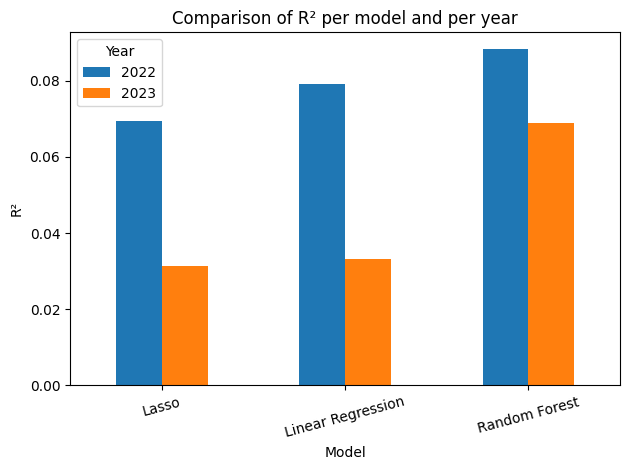

In [17]:
#Comparative Results between models
results = pd.DataFrame([
    {"Model": "Linear Regression", "Year": 2022, "R2": 0.0791, "MSE": 1468.59},
    {"Model": "Linear Regression", "Year": 2023, "R2": 0.0331, "MSE": 1075.94},
    {"Model": "Lasso",             "Year": 2022, "R2": 0.0695, "MSE": 1483.86},
    {"Model": "Lasso",             "Year": 2023, "R2": 0.0313, "MSE": 1077.97},
    {"Model": "Random Forest",     "Year": 2022, "R2": 0.0883, "MSE": 1466.88},
    {"Model": "Random Forest",     "Year": 2023, "R2": 0.0688, "MSE": 1020.31},
])

pivot_r2 = results.pivot(index="Model", columns="Year", values="R2")

plt.figure(figsize=(8,5))
pivot_r2.plot(kind="bar")
plt.title("Comparison of R² per model and per year")
plt.ylabel("R²")
plt.xlabel("Model")
plt.xticks(rotation=15)
plt.legend(title="Year")
plt.tight_layout()
plt.show()

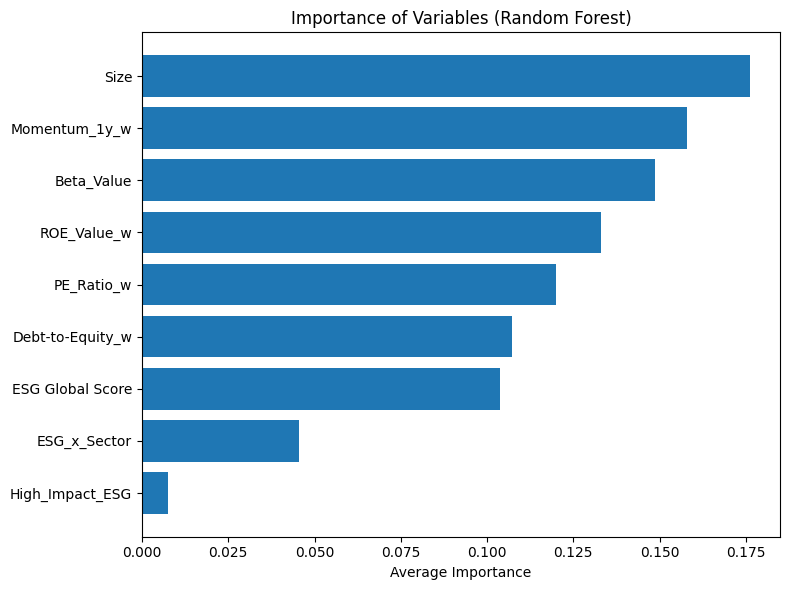

In [42]:
importances = {
    "Size": 0.176080,
    "Momentum_1y_w": 0.157940,
    "Beta_Value": 0.148709,
    "ROE_Value_w": 0.132900,
    "PE_Ratio_w": 0.120011,
    "Debt-to-Equity_w": 0.107262,
    "ESG Global Score": 0.103840,
    "ESG_x_Sector": 0.045571,
    "High_Impact_ESG": 0.007687
}

imp_series = pd.Series(importances).sort_values(ascending=True)

plt.figure(figsize=(8,6))
plt.barh(imp_series.index, imp_series.values)
plt.title("Importance of Variables (Random Forest)")
plt.xlabel("Average Importance")
plt.tight_layout()
plt.show()